In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 33.8 MB/s 
     |████████████████████████████████| 144 kB 63.2 MB/s 
     |████████████████████████████████| 181 kB 31.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4a644da51a456d65dd1d8dbb5d8f6f3740e51f26803ac8eb901e3946798de18a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
!wandb login

wandb: Currently logged in as: hyun-s (use `wandb login --relogin` to force relogin)


In [ ]:
import wandb

# wandb.init(project="gan_test", entity="hyun-s")
# wandb.run.name = 'cgan'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, os

import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
from keras.datasets import mnist,cifar10

(imgs, label), (test, t_label) = cifar10.load_data()
imgs = (imgs/127.5) - 1 
test = (test/127.5) - 1
imgs.shape

(50000, 32, 32, 3)

In [ ]:
batch = 16
buffer = 60000
input_dim = 512
n_classes = 10
img_shape=imgs[0].shape

In [ ]:
y = tf.keras.utils.to_categorical(label)


img_shape = imgs.shape[1:]
imgs_ = tf.data.Dataset.from_tensor_slices(imgs)
label = tf.data.Dataset.from_tensor_slices(y)
d_set = tf.data.Dataset.zip((imgs_,label))
d_set = d_set.shuffle(buffer).batch(batch, drop_remainder=True)
# d_set = d_set.map(lambda x: tf.reshape(x,[batch,-1]))

for x,y in d_set.take(1):
    print(x.shape,y.shape)

(16, 32, 32, 3) (16, 10)


In [70]:
%%writefile utils.py
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import scipy

class fid():
    def __init__(self, shape=(75,75,3),sample = None):
        super(fid, self).__init__()
        self.input_shape = shape
        self.resize = layers.Resizing(*self.input_shape[:2])
        self.inception = tf.keras.applications.inception_v3.InceptionV3(
                            include_top=False,
                            weights='imagenet',
                            input_shape=self.input_shape,
                            pooling=None
                        )
        self.sample = None
        if sample != None:
            self.sample = self.run(sample)
    def run(self,x):
        x = self.resize(x)
        x = self.inception(x)
        x = x.numpy()
        # x = tf.reshape(x, [x.shape[0],x.shape[-1]])
        x = x.reshape((x.shape[0],x.shape[-1]))
        return x
    def calc(self, real, fake):
        if self.sample != None:
            real = self.sample
        real = self.run(real)
        fake = self.run(fake)
        mu_r, cov_r = np.mean(real,axis=0), np.cov(real,rowvar=False)
        mu_f, cov_f = np.mean(fake,axis=0), np.cov(fake,rowvar=False)
        mu = np.linalg.norm(mu_r-mu_f)
        cov = np.trace(cov_r+cov_f -2*  scipy.linalg.sqrtm(cov_r@cov_f))
        fid = mu + cov
        if np.iscomplex(fid):
            fid = fid.real
        return fid

Writing utils.py


In [ ]:
initializer = tf.keras.initializers.HeNormal()

class PixelNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNormalization, self).__init__()
        self.epsilon = epsilon

    def call(self, inputs):
        return inputs / tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + self.epsilon)
    
    def compute_output_shape(self, input_shape):
        return input_shape

class g_block(Model):
    def __init__(self,img_size,n_channel=512):
        super(g_block, self).__init__(name='{}x{}_g_block_{}'.format(img_size,img_size,n_channel))
        self.upsampling = layers.UpSampling2D(size=2,interpolation='nearest')
        self.conv1 = layers.Conv2D(n_channel,3,1,'same',kernel_initializer=initializer)
        self.Pnorm1 = layers.BatchNormalization()
        self.act1 = layers.LeakyReLU()
        self.conv2 = layers.Conv2D(n_channel,3,1,'same',kernel_initializer=initializer)
        self.Pnorm2 = layers.BatchNormalization()
        self.act2 = layers.LeakyReLU()

    def call(self, x, training=False):
        x = self.upsampling(x)
        x = self.conv1(x,training=training)
        x = self.Pnorm1(x)
        x = self.act1(x)
        x = self.conv2(x,training=training)
        x = self.Pnorm2(x)
        x = self.act2(x)
        return x

def c_generator(input_dim, n_classes,img_shape):
    nums = 1
    w,h,c = img_shape
    w = int(w/4)
    h = int(h/4)
    inputs = layers.Input(shape = (input_dim,))
    input = layers.Dense(w*h*256)(inputs)
    input = layers.Reshape((w,h,256))(input)

    conditions = layers.Input(shape = (n_classes,))
    condition = layers.Dense(w*h*256)(conditions)
    condition = layers.Reshape((w,h,256))(condition)

    x = layers.Concatenate(axis=-1)([input,condition])
    x = layers.Reshape((w,h,512))(x)

    x = g_block(2*w,n_channel=512)(x)
    x = g_block(2*2*w,n_channel=256)(x)
    # x = g_block(32, n_channel=128)(x)

    out = layers.Conv2D(c,3,1,'same',activation='tanh')(x)
    # out = layers.Conv2D(3,3,1,activation='tanh')(x)
    model = Model(inputs=[inputs,conditions], outputs=out)
    return model

In [ ]:
g = c_generator(input_dim,n_classes,img_shape)

def z_gen(batch,input_dim):
    noise = tf.random.normal([batch,input_dim])
    condition = np.random.randint(0,n_classes,size=(batch,1))
    condition = tf.keras.utils.to_categorical(condition)
    return (noise,condition)

z,c = z_gen(batch, input_dim)
sample_img = g([z,c])
print(sample_img.shape,c.shape)

(16, 32, 32, 3) (16, 10)


In [ ]:
class d_block(Model):
    def __init__(self, img_size, n_channel=512): 
        super(d_block, self).__init__(name='{}x{}_d_block_{}'.format(img_size,img_size,n_channel))
        if n_channel==512:
            self.conv1 = layers.Conv2D(n_channel,3,1,'same',kernel_initializer=initializer)
            self.act1 = layers.LeakyReLU()
            self.conv2 = layers.Conv2D(n_channel,3,1,'same',kernel_initializer=initializer)
            self.act2 = layers.LeakyReLU()
            self.down = layers.AveragePooling2D(2)
        else:
            self.conv1 = layers.Conv2D(n_channel,3,1,'same',kernel_initializer=initializer)
            self.act1 = layers.LeakyReLU()
            self.conv2 = layers.Conv2D(n_channel*2,3,1,'same',kernel_initializer=initializer)
            self.act2 = layers.LeakyReLU()
            self.down = layers.AveragePooling2D(2)

    def call(self, x, training=False):
        x = self.conv1(x,training=training)
        x = self.act1(x)
        x = self.conv2(x,training=training)
        x = self.act2(x)
        x = self.down(x)
        return x

def c_discriminator(img_shape, n_classes):
    w,h,c = img_shape
    w = int(w/4)
    h = int(h/4)
    inputs = layers.Input(shape = img_shape)
    conditions = layers.Input(shape = (n_classes,))

    condition = layers.Dense(4*w*4*h*c)(conditions)
    condition = layers.Reshape((4*w,4*h,c))(condition)

    input = layers.Concatenate(axis=-1)([inputs,condition])

    # x = d_block(32,n_channel=128)(input)
    x = d_block(4*w,n_channel=128)(input)
    x = d_block(2*w,n_channel=256)(x)
    x = d_block(w,n_channel=256)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='sigmoid')(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inputs,conditions], outputs=x)
    return model

In [ ]:
d = c_discriminator(img_shape,n_classes)

d([sample_img,c])

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.36958876],
       [0.36950424],
       [0.36932373],
       [0.3697824 ],
       [0.37014827],
       [0.36898562],
       [0.36965683],
       [0.3693654 ],
       [0.3687598 ],
       [0.36943823],
       [0.36919117],
       [0.3694297 ],
       [0.36908376],
       [0.3696734 ],
       [0.36974916],
       [0.37012175]], dtype=float32)>

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def d_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def g_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

g_opt = tf.optimizers.Adam(0.0002, 0.5)
d_opt = tf.optimizers.Adam(0.0002, 0.5)

In [ ]:
@tf.function
def train_step(images,real_c):
    noise,condition = z_gen(batch,input_dim)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = g([noise,condition], training=True)

        real_output = d([images,real_c], training=True)
        fake_output = d([generated_images,condition], training=True)

        gen_loss = g_loss(fake_output)
        disc_loss = d_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, g.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, d.trainable_variables)

    g_opt.apply_gradients(zip(gradients_of_generator, g.trainable_variables))
    d_opt.apply_gradients(zip(gradients_of_discriminator, d.trainable_variables))

    return gen_loss,disc_loss

for x in d_set.take(2):
    noise,condition = z_gen(batch,input_dim)
    aa,bb = train_step(*x)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [ ]:
from IPython import display

x = tf.random.normal([10,input_dim])
c = [x for x in range(10)]
c = tf.keras.utils.to_categorical(c)
sample=(x,c)
def generating_img_plot(g,sample = None):
    if sample == None:
        x = tf.random.normal([batch,input_dim])
        c = [x for x in range(10)]
        c = tf.keras.utils.to_categorical(c)
    else:
        x = sample
    imgs = g([x[0],x[1]]).numpy()
    rows = 2
    cols = 5
    fig = plt.figure(figsize=(16,8))

    for idx, (img,c) in enumerate(zip(imgs,x[1])):
        img = (np.max(img) - img) / (np.max(img) - np.min(img))
        
        ax = fig.add_subplot(rows, cols, idx+1)
        ax.set_title('Digit : {}'.format(np.argmax(c)))
        if img.shape[-1] != 3:
            img = img.reshape((28,28))
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)

        ax.axis('off')
    plt.show()
    fig.savefig('full_figure.png')
    return imgs,np.argmax(x[1],axis=0)

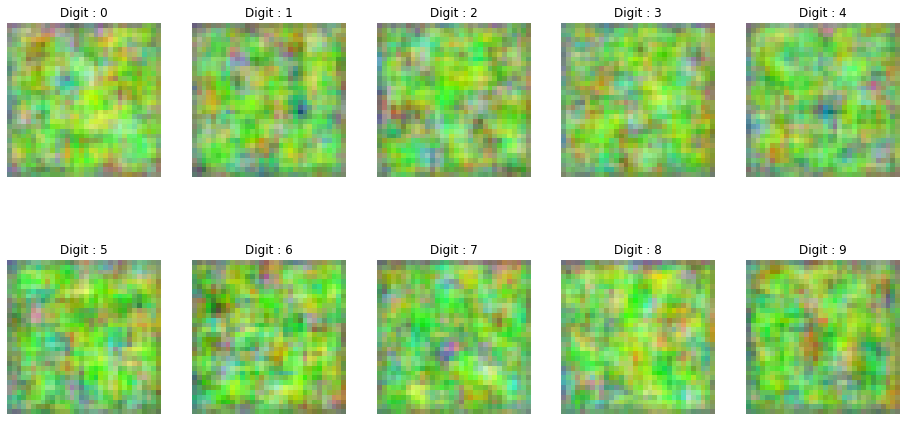

KeyboardInterrupt: ignored

In [69]:
import wandb
wandb.init(project="gan_test", entity="hyun-s",name='cgan_f')
wandb.run.name = 'cgan_f'

# f = fid()
fids=0
g = c_generator(input_dim,n_classes,img_shape)
d = c_discriminator(img_shape,n_classes)
for epoch in range(100):
    d_losses = []
    g_losses = []
    for idx, (img,cls) in enumerate(d_set):
        
        dis_loss,gen_loss = train_step(img,cls)
        display.clear_output(wait=True)
        i,c = generating_img_plot(g,sample)
        # fids = f.calc(img,i)
        d_losses.append(dis_loss.numpy())
        g_losses.append(gen_loss.numpy())
        wandb.log({"g_loss": gen_loss.numpy()})
        wandb.log({"d_loss": dis_loss.numpy()})
        # wandb.log({"fid": np.float32(fids)})
        wandb.log({'Generate Image' : wandb.Image('/content/full_figure.png')})
        print('{}epoch, {}batch | G_loss: {:.4f}, D_loss: {:.4f}, FID: {:.4f}'.format(
            epoch,idx,g_losses[-1],d_losses[-1],fids))
    g_losses = np.mean(g_losses)
    d_losses = np.mean(d_losses)